### Required imports

In [128]:
from arch import arch_model
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from pandas_datareader import DataReader
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.vector_ar.vecm import VECM
from dsutils import adfuller_test, cointegration_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import warnings

# To ignore all warnings in model output
warnings.filterwarnings("ignore")


register_matplotlib_converters()
sns.set()
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Volatility Analysis

### 1- Model choice

Stock returns have an asymmetric shock. It is often the case. A piece of “bad news”, or a negative return, such as a drop in the stock price, reduces the value of equity relative to the fixed value of debt of that firm according to Enders (2014). The opposite effect will also be present – an increase in the stock price reduces leverage and risk. It is also often the case, that stocks move more often with the market when the market goes down than when it goes up(Yongmiao Hong et al. , The Review of Financial Studies, 2007). EGARCH model is well suited to model such asymmetric shocks. It adds a conditional component to model the asymmetry in shocks similar to the GJR-GARCH and it doesn't have a non-negative constraint on alpha and beta, making the model faster.

#### Plot of the returns

<Figure size 1080x360 with 0 Axes>

Text(0, 0.5, 'Returns(%)')

Text(0.5, 1.0, 'AAPL Returns')

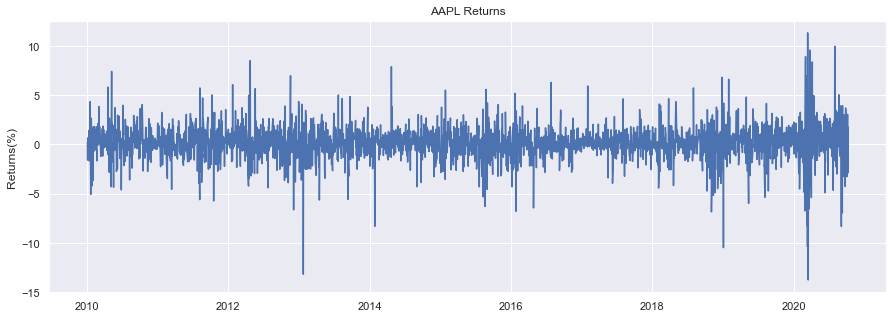

In [2]:
start_date = datetime(2010, 1, 1)
end_date = datetime(2020, 10, 9)
aapl = DataReader("AAPL", "yahoo", start_date, end_date)
returns = pd.DataFrame(np.diff(np.log(aapl["Adj Close"].values)))
returns = 100 * returns
returns.index = aapl.index.values[1 : aapl.index.values.shape[0]]
returns.columns = ["AAPL Returns"]

plt.figure(figsize=(15, 5))
plt.plot(returns.index, returns)
plt.ylabel("Returns(%)")
plt.title("AAPL Returns")

One way to visualize the underlying volatility of the series is to plot the absolute returns ∣y∣:

<Figure size 1080x360 with 0 Axes>

Text(0, 0.5, 'Absolute Returns(%)')

Text(0.5, 1.0, 'Apple Absolute Returns')

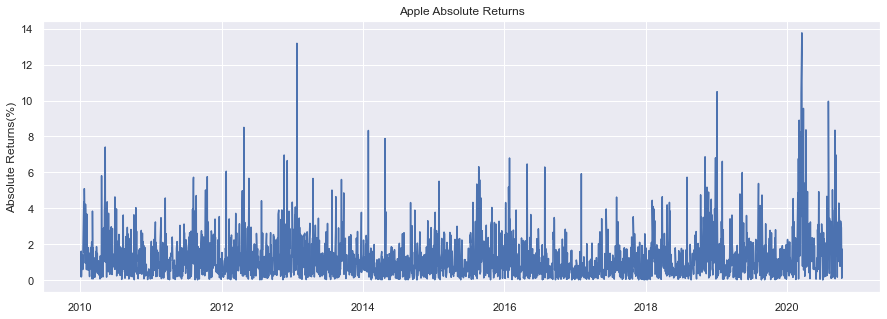

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(returns.index, np.abs(returns))
plt.ylabel("Absolute Returns(%)")
plt.title("Apple Absolute Returns")

#### Model specification

Iteration:     10,   Func. Count:     99,   Neg. LLF: 4760.994056625304
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4760.871301667804
            Iterations: 15
            Function evaluations: 140
            Gradient evaluations: 15
                             AR - EGARCH Model Results                              
Dep. Variable:                 AAPL Returns   R-squared:                      -0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4760.87
Distribution:      Standardized Student's t   AIC:                           9533.74
Method:                  Maximum Likelihood   BIC:                           9568.96
                                              No. Observations:                 2618
Date:                      Mon, Oct 12 2020   Df Residuals:                     2612
Time:                              21

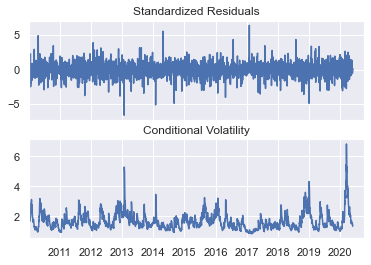

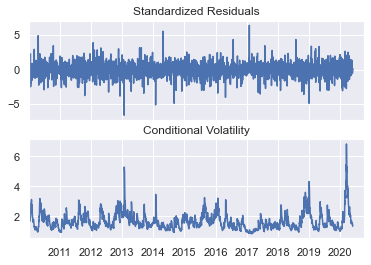

In [4]:
# Specify EGARCH model assumptions
basic_gm = arch_model(returns, p=1, q=1, o=1, mean="AR", vol="EGARCH", dist="t")
# Fit the model
split_date = datetime(2020, 6, 1)
gm_result = basic_gm.fit(update_freq=10, last_obs=split_date)

# Display model fitting summary
print(gm_result.summary())

# Plot fitted results
gm_result.plot()
plt.show()

The coefficients are all significant at the 1% significant level as p-values for all coefficient is less than 1%. The abslolute value of the t-values are all greater than 2 as well. alpha is greater than 0.10 which indicates a spily market as clearly shown on the conditional volatility plot. beta is 0.94 which is in the high end for daily data according to Alexander(2008), meaning that the volatility has high persistency or otherwise stated, past volatility have high impact on current volatility.

#### Analysis of model residuals

(array([1.000e+00, 4.000e+00, 2.300e+01, 1.470e+02, 1.031e+03, 1.186e+03,
        2.020e+02, 1.800e+01, 4.000e+00, 2.000e+00]),
 array([-6.6010783 , -5.30090723, -4.00073615, -2.70056508, -1.40039401,
        -0.10022293,  1.19994814,  2.50011922,  3.80029029,  5.10046137,
         6.40063244]),
 <BarContainer object of 10 artists>)

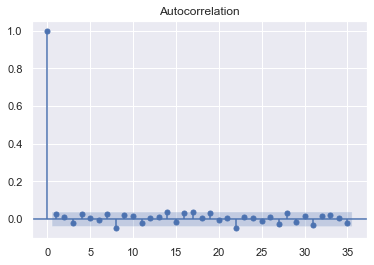

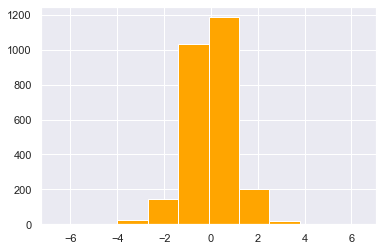

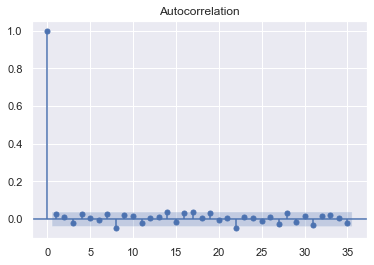

In [5]:
std_resid = gm_result.resid / gm_result.conditional_volatility
std_resid.dropna(inplace=True)
plt.hist(std_resid, facecolor="orange", label="standardized residuals")
plot_acf(std_resid, alpha=0.05)

In [6]:
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(std_resid, lags=10, return_df=True)
# Check p-values
lb_test.lb_pvalue

1     0.191196
2     0.377703
3     0.389669
4     0.318130
5     0.447848
6     0.552290
7     0.461829
8     0.093471
9     0.106428
10    0.122627
Name: lb_pvalue, dtype: float64

The pvalue of residuals up to lag 10 is greater than 0.01, so we accept the null hypothesis of residuals that are independently distributed, i.e, there is no autocorrelation in the residuals

The model will be estimated using the first 10 years and 4 months to estimate parameters and then forecasts will be produced for the final period in the sample.

### 2- One step ahead Forecast

In [7]:
# Make 1-period ahead forecast
gm_forecast = gm_result.forecast(method="simulation", start=split_date)

# Print the forecast variance
print(gm_forecast.mean[-1:])

                h.1
2020-10-09  0.12645


## Multivariate Analysis
### Equilibrium CAD/USD Exchange Rate

### 1- Describe the economic theories and models used to calculate equilibrium FX

### 2- Indicate macroeconomic variables used to determine the equilibrium FX

### 3- Explain the connection between linear regression and Vector Error Correction (VEC)
Linear regression attempts to model the relationship between two or more variables by fitting a linear equation to observed data. One or more variable are considered to be independent variables, and one variable is considered to be a dependent variable.
The vector auto-regression is a system of regression which contains a set of `m` variables, each of which is expressed as a linear function of `p` lags of itself and of all of the other `m – 1` variables, plus an error term. Both linear regression and VAR use OLS to estimate paramters. When the variables of a VAR are cointegrated, we use a vector error-correction (VEC) which is a special case of VAR.

### 4- Calculate the equilibrium FX using VEC and comment all your results

#### Get relevant data

In [8]:
import os
import quandl

In [12]:
API_KEY = os.environ.get("quandl_api_key")
quandl.ApiConfig.api_key = API_KEY

In [19]:
CPI_CAN = quandl.get(
    "RATEINF/CPI_CAN",
    authtoken=API_KEY,
    start_date="2003-03-31",
    end_date="2020-03-31",
    collapse="quarterly",
)
CPI_US = quandl.get(
    "RATEINF/CPI_USA",
    authtoken=API_KEY,
    start_date="2003-03-31",
    end_date="2020-03-31",
    collapse="quarterly",
)
CAN_5Y = quandl.get(
    "BOC/V122540",
    authtoken=API_KEY,
    start_date="2003-03-31",
    end_date="2020-03-31",
    collapse="quarterly",
)
US_5Y = quandl.get(
    "USTREASURY/REALYIELD",
    authtoken=API_KEY,
    column_index="1",
    start_date="2003-03-31",
    end_date="2020-03-31",
    collapse="quarterly",
)

##### The FX data is a premium feature on Quandl so we used an alternative API.

In [17]:
url = "https://api.exchangeratesapi.io/history?start_at=2003-01-31&end_at=2020-03-31&symbols=CAD&base=USD"
response = requests.get(url)
data = response.json()
dates = sorted(data["rates"].keys())
dates = pd.to_datetime(dates)
exch_rates = []
for key_val in list(data["rates"].values()):
    exch_rates.append(key_val["CAD"])
exch_rate_data = {"FX": exch_rates}
USDCAD_daily = pd.DataFrame(data=exch_rate_data, index=dates)

# Transform the FX data to quarterly data
USDCAD = USDCAD_daily.resample("Q").mean()

In [20]:
# vecm_data = USDCAD.copy(deep=True)
vecm_data = pd.concat(
    [USDCAD, CPI_CAN, CPI_US, CAN_5Y, US_5Y],
    axis=1,
)
vecm_data.columns = ["FX", "CPI_CAN", "CPI_US", "CAN_5Y", "US_5Y"]

In [22]:
vecm_data.describe()

,FX,CPI_CAN,CPI_US,CAN_5Y,US_5Y
count,69.000000,69.000000,69.000000,69.000000,69.000000
mean,1.177532,119.463768,223.129913,2.361594,0.552899
std,0.016067,10.043230,21.404808,1.188803,0.962815
min,1.144404,102.500000,183.700000,0.590000,-1.490000
25%,1.165708,111.900000,208.352000,1.400000,0.010000
50%,1.177052,120.200000,225.722000,1.950000,0.450000
75%,1.188249,127.200000,238.343000,3.550000,1.130000
max,1.211252,136.600000,258.115000,4.620000,2.590000


Because the PPP equation is expressed in terms of logarithm of prices and exchange rate, we create a new dataframe by turning these variables into their logarithm(ppp_df), but we do not change the scale of the UIRP(uirp_df), then we join both dataframes for our modelling

In [23]:
ppp_df = np.log(vecm_data.loc[:, ["FX", "CPI_CAN", "CPI_US"]])
uirp_df = vecm_data.loc[:, ["CAN_5Y", "US_5Y"]]
log_vecm = pd.concat([ppp_df, uirp_df], axis=1)
log_vecm.to_csv("log_vecm.csv")

<AxesSubplot:>

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

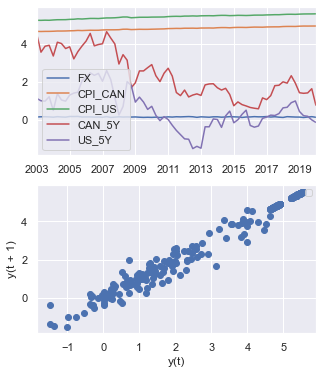

In [129]:
import matplotlib as mpl

# mpl.rcParams["figure.dpi"] = 200
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 6))
log_vecm.plot(ax=ax1)
pd.plotting.lag_plot(log_vecm)
plt.legend(loc=1, fontsize="x-small")
plt.show()

#### Split the data into train and test set

The VECM model will be fitted on df_train and then used to forecast the next 10 observations. These forecasts will be compared against the actuals present in test data.

In [93]:
nobs = 4
vecm_train, vecm_test = vecm_data.iloc[:-nobs], vecm_data.iloc[-nobs:]
# Check size
print(vecm_train.shape)  # (59, 5)
print(vecm_test.shape)  # (10, 5)

(65, 5)
(4, 5)


#### Stationarity check

In [130]:
# ADF Test on each column
for name, column in vecm_train.iteritems():
    adfuller_test(column, name=column.name)
    print("\n")

    Augmented Dickey-Fuller Test on "FX" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.3888
 No. Lags Chosen       = 0
 Critical value 1%     = -3.537
 Critical value 5%     = -2.908
 Critical value 10%    = -2.591
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CPI_CAN" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.1423
 No. Lags Chosen       = 10
 Critical value 1%     = -3.558
 Critical value 5%     = -2.917
 Critical value 10%    = -2.596
 => P-Value = 0.9451. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "CPI_US" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 

#### Johansen Cointegrating Test
In order to fit a VECM model, we need to determine the number of co-integrating relationships using a VEC rank test.

In [95]:
cointegration_test(vecm_data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
FX     ::  81.67     > 60.0627   =>   True
CPI_CAN ::  48.32     > 40.1749   =>   True
CPI_US ::  20.03     > 24.2761   =>   False
CAN_5Y ::  6.21      > 12.3212   =>   False
US_5Y  ::  1.22      > 4.1296    =>   False


Let’s estimates the VECM on the economic variables with 10 lags.The cointegration test is significant for 2 variables, so the cointegration rank is 2. Let's use ‘cili’ a combination of “ci” — constant within the co-integration relation and “li” — linear trend within the co-integration relation

In [108]:
vecm_model = VECM(endog=vecm_train, k_ar_diff=4, coint_rank=2, deterministic="co")
vecm_fit = vecm_model.fit()
vecm_fit.summary().tables[0]

,coef,std err,z,P>|z|,[0.025,0.975]
const,1.5710,0.364,4.320,0.000,0.858,2.284
L1.FX,0.2640,0.255,1.035,0.300,-0.236,0.764
L1.CPI_CAN,-0.0169,0.007,-2.541,0.011,-0.030,-0.004
L1.CPI_US,0.0097,0.003,3.124,0.002,0.004,0.016
L1.CAN_5Y,-0.0166,0.007,-2.242,0.025,-0.031,-0.002
L1.US_5Y,0.0122,0.007,1.808,0.071,-0.001,0.025
L2.FX,0.0726,0.212,0.342,0.732,-0.343,0.488
L2.CPI_CAN,-0.0124,0.007,-1.799,0.072,-0.026,0.001
L2.CPI_US,0.0069,0.003,2.097,0.036,0.000,0.013
L2.CAN_5Y,-0.0129,0.008,-1.617,0.106,-0.029,0.003


In [109]:
forecast, lower, upper = vecm_fit.predict(4, 0.05)
print("lower bounds of confidence intervals:")
print(np.round(lower, 3))
print("\npoint forecasts:")
print(forecast.round(3))
print("\nupper bounds of confidence intervals:")
print(upper.round(3))

lower bounds of confidence intervals:
[[ 1.16300e+00  1.36023e+02  2.56870e+02  1.67800e+00  6.12000e-01]
 [ 1.16200e+00  1.35469e+02  2.54954e+02  1.25200e+00  7.98000e-01]
 [ 1.16800e+00  1.35428e+02  2.53829e+02  5.25000e-01  1.82000e-01]
 [ 1.16700e+00  1.37002e+02  2.56934e+02  2.99000e-01 -2.91000e-01]]

point forecasts:
[[  1.187 137.057 259.42    2.278   1.209]
 [  1.187 136.647 258.302   2.124   1.752]
 [  1.193 136.646 257.679   1.511   1.301]
 [  1.193 138.411 261.5     1.424   0.999]]

upper bounds of confidence intervals:
[[  1.211 138.092 261.97    2.878   1.807]
 [  1.212 137.824 261.649   2.995   2.707]
 [  1.218 137.865 261.529   2.497   2.419]
 [  1.219 139.819 266.067   2.549   2.29 ]]


In [110]:
forecast_df = pd.DataFrame(forecast, index=vecm_test.index, columns=vecm_test.columns)
forecast_df.rename(lambda x: f"{x}_forecast", axis=1, inplace=True)
forecast_df

,FX_forecast,CPI_CAN_forecast,CPI_US_forecast,CAN_5Y_forecast,US_5Y_forecast
2019-06-30,1.187443,137.057080,259.419784,2.277965,1.209279
2019-09-30,1.187358,136.646707,258.301565,2.123599,1.752496
2019-12-31,1.193028,136.646402,257.679260,1.510819,1.300525
2020-03-31,1.193249,138.410601,261.500304,1.423632,0.999407


#### Plot Forecast vs Actuals

<AxesSubplot:>

Text(0.5, 1.0, 'FX: Forecast vs Actuals')

<AxesSubplot:>

Text(0.5, 1.0, 'CPI_CAN: Forecast vs Actuals')

<AxesSubplot:>

Text(0.5, 1.0, 'CPI_US: Forecast vs Actuals')

<AxesSubplot:>

Text(0.5, 1.0, 'CAN_5Y: Forecast vs Actuals')

<AxesSubplot:>

Text(0.5, 1.0, 'US_5Y: Forecast vs Actuals')

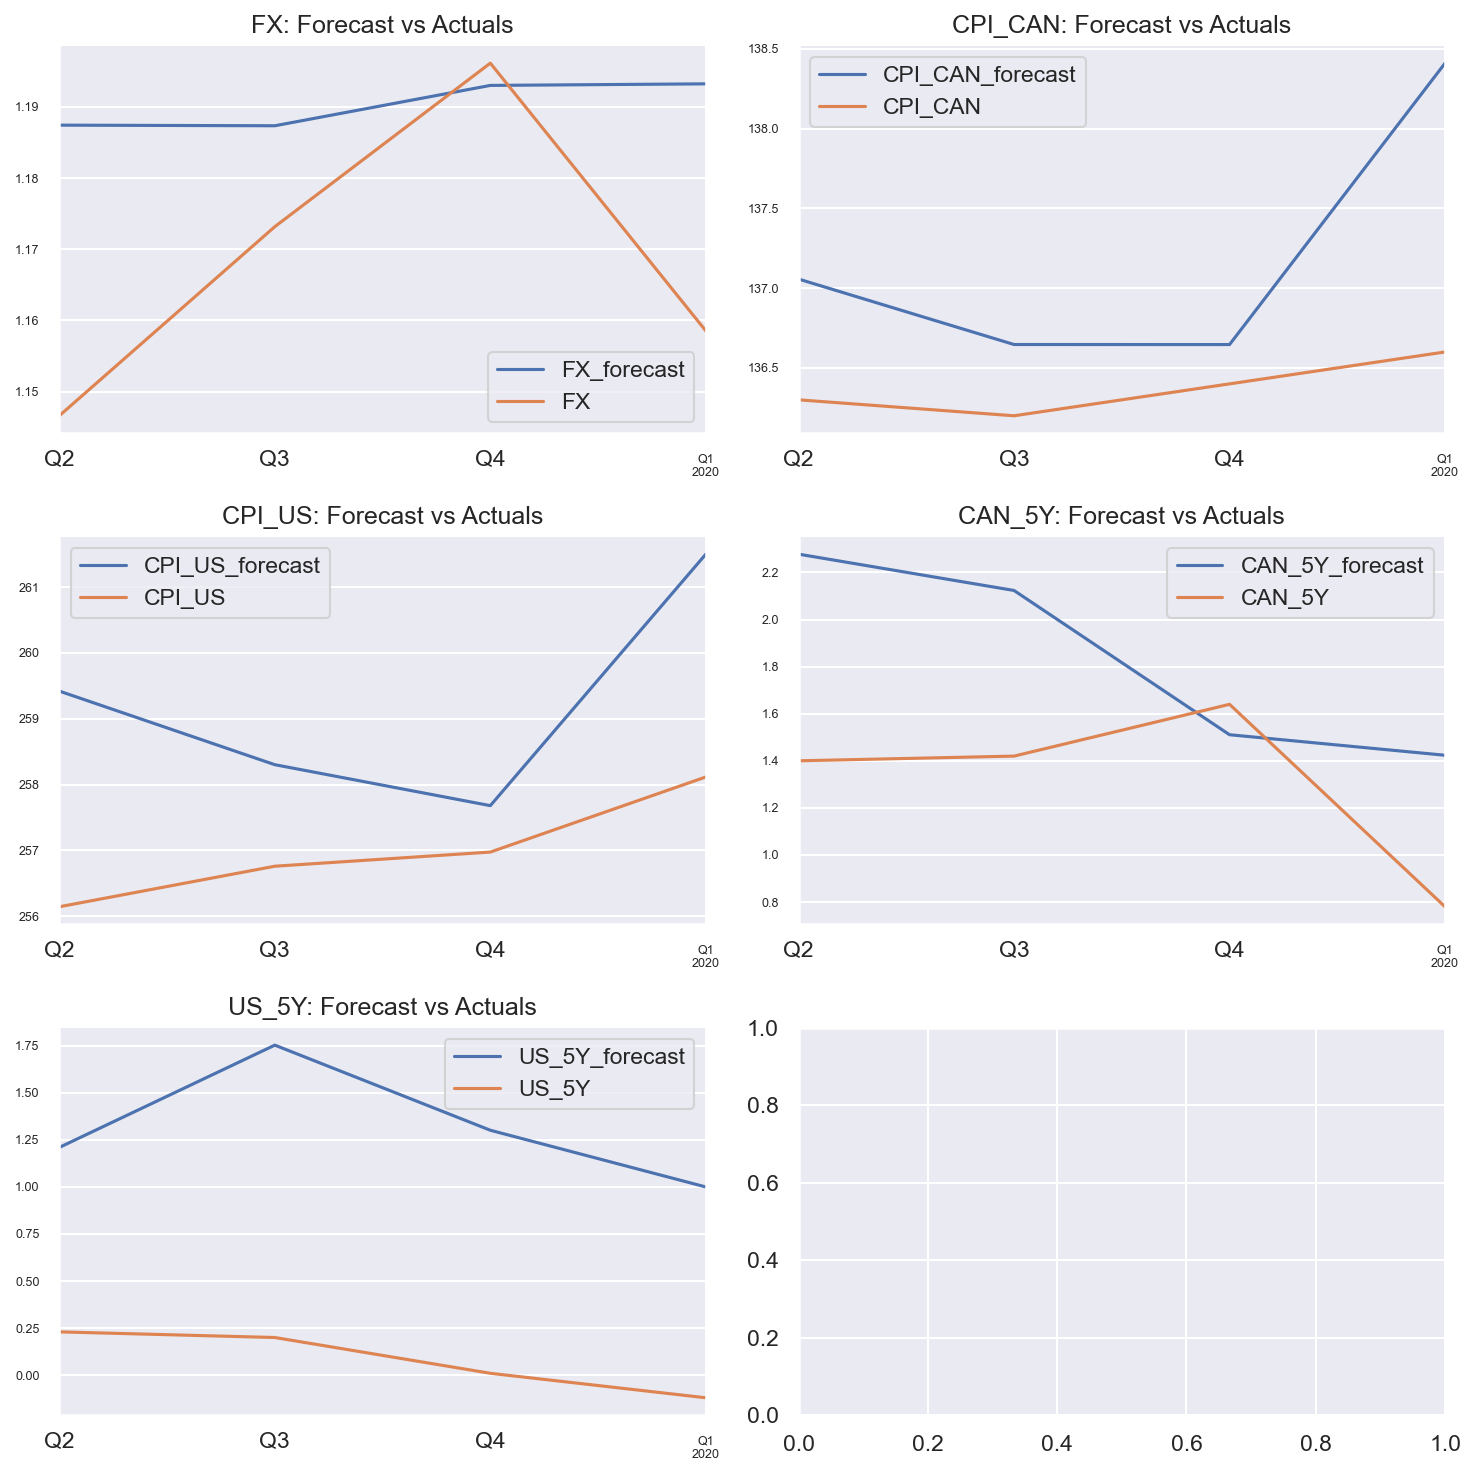

In [131]:
fig, axes = plt.subplots(
    nrows=int(len(vecm_data.columns) / 2 + 1), ncols=2, dpi=150, figsize=(10, 10)
)
for i, (col, ax) in enumerate(zip(vecm_data.columns, axes.flatten())):
    forecast_df[f"{col}_forecast"].plot(legend=True, ax=ax).autoscale(
        axis="x", tight=True
    )
    vecm_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position("none")
    ax.yaxis.set_ticks_position("none")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

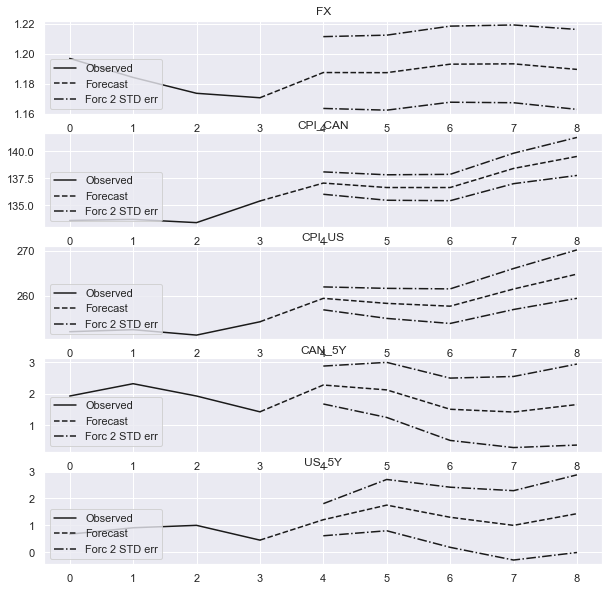

In [114]:
vecm_fit.plot_forecast(steps=, n_last_obs=nobs)

### Structural Analysis

#### Granger causality

In [121]:
for var in vecm_data.columns:
    granger_results = vecm_fit.test_granger_causality(caused=var, signif=0.05)
    print(granger_results.summary())

Granger causality F-test. H_0: %s do not Granger-cause FX. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.568          1.646   0.069 (20, 140)
-----------------------------------------------
Granger causality F-test. H_0: %s do not Granger-cause CPI_CAN. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         3.149          1.646   0.000 (20, 140)
-----------------------------------------------
Granger causality F-test. H_0: %s do not Granger-cause CPI_US. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         4.363          1.646   0.000 (20, 140)
-----------------------------------------------
Granger causality F-test. H_0: %s do not Granger-cause CAN_5Y. Conclusion: reject H

In [123]:
for var in vecm_data.columns:
    inst_results = vecm_fit.test_inst_causality(causing=var, signif=0.05)
    print(inst_results.summary())

Instantaneous causality Wald-test. H_0: FX does not instantaneously cause [CPI_CAN, CPI_US, CAN_5Y, US_5Y]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         15.09          9.488   0.005  4
----------------------------------------
Instantaneous causality Wald-test. H_0: CPI_CAN does not instantaneously cause [FX, CPI_US, CAN_5Y, US_5Y]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         26.48          9.488   0.000  4
----------------------------------------
Instantaneous causality Wald-test. H_0: CPI_US does not instantaneously cause [FX, CPI_CAN, CAN_5Y, US_5Y]. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         27.65          9.488   0.000  4
----------------------------------------
Instantaneous causality Wald-test. H_

#### Impulse Response Analysis

To analyze how an impulse in one variable affects the system, we can use the irf() method and call the returned object's plot method.

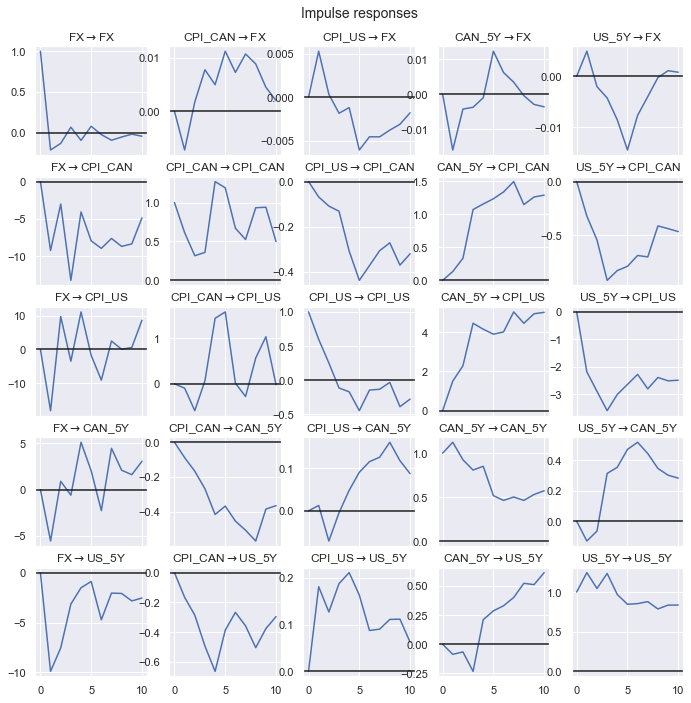

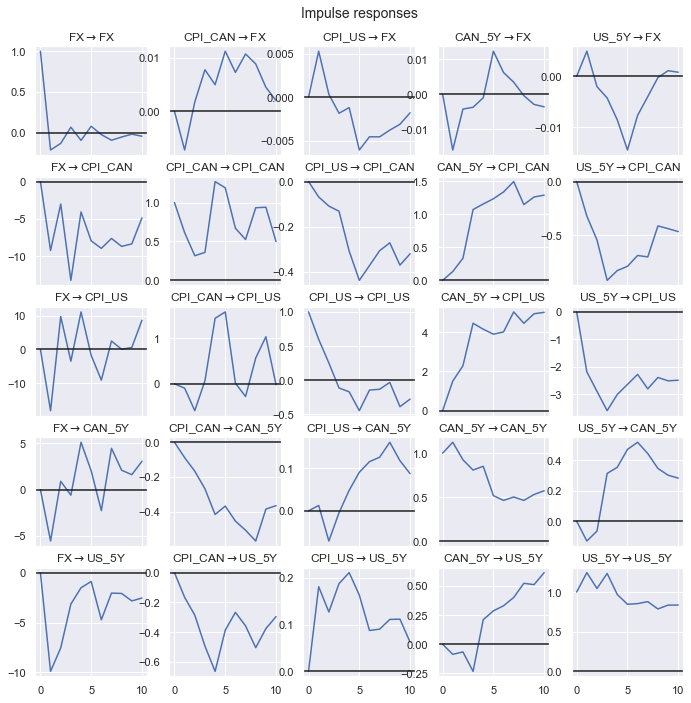

In [124]:
num_periods = 10
ir = vecm_fit.irf(periods=num_periods)
ir.plot(plot_stderr=False)

#### Test diagnostics

##### Testing for normality

In [125]:
norm_test = vecm_fit.test_normality()
norm_test.summary()

Test statistic,Critical value,p-value,df
3.702,18.31,0.960,10


##### Checking for residuals autocorrelation

In [127]:
white_test = vecm_fit.test_whiteness(nlags=6, adjusted=True)
white_test.summary()

Test statistic,Critical value,p-value,df
80.11,55.76,0.000,40
